# DCGAN keras Imagenes 64 x 64

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [4]:
from __future__ import print_function, division

#Se importan las bibliotecas. En caso de querer hacer este proceso directamente
#en un ordenador se deben instalar las bilbiotecas que se indican a continuacion:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
import glob
import keras
import time
import imp
import os
import tensorflow as tf 
import pandas as pd
import sys

#Estas bibliotecas no son necesarias en su totalidad, solo se requieren ciertas
#funciones
from random import shuffle
from skimage import io
from collections import Counter
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

from keras.datasets import mnist

#Importe de funciones especificas de bibliotecas ya importadas
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization, ZeroPadding2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import UpSampling2D
from keras.optimizers import SGD, Adam

from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from keras.datasets.mnist import load_data

from scipy.stats import wasserstein_distance

#lineas requeridas solo en jupyter notbook
from IPython.display import clear_output
%matplotlib notebook
%matplotlib inline
#%tensorflow_version 2.x

## Lectura de datos

In [5]:
#Se inicia definiendo el diccionario map_characters, este posee originalmente 18
#personajes, si se agrega otro más se debe agregar al diccionario y colocarsele 
#el número consecutivo que corresponda

map_characters = {0: 'trainingCoffee'}
                  
#Se define el numero de clases con la extensión del diccionario
num_classes = len(map_characters)

#Número máximo de imagenes que se usaran por personaje para entrenar
pictures_per_class = 20000

def load_pictures(test_size, pic_size,BGR):
    """
    Load pictures from folders for characters from the map_characters dict and create a numpy dataset and 
    a numpy labels set. Pictures are re-sized into picture_size square.
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: dataset, labels set
    """
    pics = []    #Se crea la lista de imagenes de salida
    labels = []  #Se crea la lista de etiquetas de salida

    #k es el numero de la variable en el diccionario
    #char es el nombre de la variable en el diccionario
    # El if lo que hace es que recorra cada una de las variables del diccionario
    for k, char in map_characters.items(): 

        #Esta linea deivuelve la lista de rutas de las imagenes de cada personaje del diccionario
        # Ej: para char = 'abraham_grampa_simpson' regresa todas las rutas de imagen de la carpeta
        # abraham_grampa_simpson que a su vez esta en la carpeta characters.
        #Es solo una forma elegante y rapida de optener todas las rutas
        pictures = [k for k in glob.glob('./source/trainingSet/%s/*' % char)]

        #Se establece la cantidad de imagenes que se van a usar en cada clase
        #Como maximo se usan 1176 imagenes, estas son tanto para train como para test
        #Si el personaje en particular tiene menos de 1176 imagenes se usara la extension del personaje en cuestion
        nb_pic = round(pictures_per_class/(1-test_size)) if round(pictures_per_class/(1-test_size))<len(pictures) else len(pictures)

        #Se usa la funcion random para ordenar de manera aleatoria las imagenes de cada personaje
        #Cabe detacar que pic es una ruta de acceso aleatoria de la lista de rutas de acceso en pictures
        for pic in np.random.choice(pictures, nb_pic):

            #Se lee la imagen de la ruta "pic"
            a = cv2.imread(pic)
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            # a = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)

            #Se hace un resize de las imagenes a pic_size x pic_size. Por defecoto
            #este es 64x64. Esto concuerda con los pixeles de entrada de la red neuronal
            a = cv2.resize(a, (pic_size,pic_size))

            #Se agrega la imagen leida, convertida y escalada a la lista pics
            pics.append(a)
            #Se agrega la etiqueta numérica de la lista de etiquetas, esta etiqueta numerica 
            #concuerda con el número en el diccionario map_characters
            labels.append(k)

    #Se devuelve las listas pero antes se transforman a un formato de array con numpy
    return np.array(pics), np.array(labels) 

def get_dataset(save=False, load=False, BGR=False, test_size=0.1, pic_size=64):
    #Primero se llama a la funcion load_pictures, por defecto se deja estas en 
    #blanco y negro
    #En esta funcion tambien se extraen los labels del archivo txt anotations
    X, y = load_pictures(test_size, pic_size, BGR)

    #Luego se pasa los labels a un formato numerico y en listas separadas,
    #por ejemplo si el label es 2 to_categorical lo pasa a una lista [0 0 1 ... 0]
    #El tamaño de la lista depende de cuantas clases se tenga, en este ejemplo son 18
    y = keras.utils.to_categorical(y, num_classes)

    #Se normaliza las imagenes para que los valores de cada banda esten en punto flotante
    #y además se encuentren entre 0 y 1. Esto ayuda a la velocidad de entrenamiento           
    X = X.astype('float32') / 255.
    
    #Se imprime las formas de cada tensor. Si se mantienen todas las variables 
    #por defecto estas deben ser (x,64,64,3) y (x,w), donde x es el numero de imagenes
    #y w es la cantidad de clases en el diccionario
    print("Train", X.shape, y.shape)

    return X, y

#Uso de funciones de lectura para dividir el set de imagnes en test y train
X, y = get_dataset(save=True)

Train (19017, 64, 64, 3) (19017, 1)


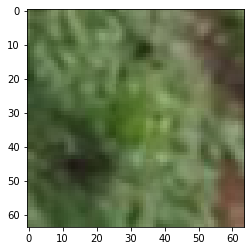

In [6]:
plt.imshow(X[0])
plt.show()

## Hiper Parametros

In [7]:
#Dimensiones de imagen
img_rows = 64
img_cols = 64
channels = 3
latent_dim = 100
img_shape = (img_rows, img_cols, channels)
img_shape

#Filtros y configuracion de red
Filtros_Iniciales = 64  #Filtros iniciales en la primera capa de la generadora
upsample_layers = 5     #Cantidad de layers que se tienen en la red generadora
Kernels = 5             #Dimenciones de los filtros ejemplo: Kernels = 3 equivale a filtros 3x3

#Optimizador Adam
lr  = 0.0002 
b_1 = 0.5    #Beta 1

## Configuración de las Redes

Para la generación de imágenes se usará la aproximación GANs con dos redes convolucionales que compiten entre ellas, una se encarga de distinguir entre imágenes de café (Red Discriminadora) y la otra en tratar de engañar a la primera (Red Generadora).

![Sistem_diagram](ReadMe_Images/Sistema.png)

### Arquitectura de Red Generadora

![Gen_diagram](ReadMe_Images/Gen.png)

In [8]:
def build_generator():
    noise_shape = (latent_dim,)
    
    model = Sequential()

    model.add(Dense(Filtros_Iniciales * (img_rows // (2 ** upsample_layers))  *  (img_cols // (2 ** upsample_layers)), activation="relu", input_shape=noise_shape))
    model.add(Reshape(((img_rows // (2 ** upsample_layers)),
                       (img_cols // (2 ** upsample_layers)),
                       Filtros_Iniciales)))
    
    model.add(BatchNormalization(momentum=0.8))
        
    model.add(UpSampling2D())
    model.add(Conv2D(1024, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(512, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(channels, kernel_size=Kernels, padding="same"))
    model.add(Activation("tanh"))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    fake_img = model(noise)

    return Model(noise, fake_img)

### Arquitectura de Red Discriminadora

![Dis_diagram](ReadMe_Images/Dis.png)

In [9]:
def build_discriminator():

    #Se crea primeramente un modelo "Sequential", este es el tipo de red neuronal
    #existen otros tipos como las recursivas y las recurrentes.
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=img_shape))
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    #Finalmente se reduce a la cantidad de neuronas equivalentes a la cantidad de clases
    #que se desean, en nuestro caso, la cantidad de personajes que estamos clasificando
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

## Funciones de entrenamiento

In [10]:
def train(X_train, epochs_inicial, epochs, batch_size=128, save_interval=50):
 
    #La mitad del bach es imagenes falsas y la otra mitad imagenes reales
    half_batch = int(batch_size / 2)

    # Adversarial ground truths
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    
    for epoch in range(epochs_inicial, epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        # Se seleccionan imagenes aleatorias para hacer la epoca
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # El generador da un numero de imagenes sinteticas para la epoca
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        gen_imgs = generator.predict(noise)

        #Se entrena con las imagenes reales
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        
        #Se entrena con las imagenes creadas como falsas
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        #  Train Generator
        # ---------------------

        # Se ingresa el ruido al generador y la idea es que
        # el generador engañe al discriminador para que piense que es
        # una imagen real, por eso ponemos que el ruido es valido
        # Aqui solo se modifian los pesos del generador
        g_loss = combined.train_on_batch(noise, valid)   
        
        #----------------------------------------------------------------------
        #Se guarda los resultados en una lista
        itr_list.append(epoch)
        acc_list.append(100*d_loss[1])
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss)
        
        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            print ("%d Discriminator_loss: %f acc.: %.2f%% Generator_loss: %f" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            save_imgs(epoch)
            
        if epoch == epochs - 1:
            #Cuendo termina el entrenamiento se guardan en un df
            df = pd.DataFrame()
            df['itr'] = itr_list
            df['acc'] = acc_list
            df['d_loss'] = d_loss_list
            df['g_loss'] = g_loss_list
            df.to_csv('results_cafe.csv', index=False)

In [11]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = abs(gen_imgs)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow((gen_imgs[cnt] * 255).astype(int))
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("Resultados_Cafe/itr_%d.png" % epoch)
    plt.close()

## Main part

### Entrenamiento desde cero

In [12]:
#Se pone el optimizador junto con los hiper parametros
optimizer = Adam(lr, b_1)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)       

In [13]:
#-------------------------------------
itr_list = []
acc_list = []
d_loss_list = []
g_loss_list = []

#Train!!!
# En esta sección se ven algunos errores al principio, es normal y los resultados apareceran 
# en una frecuencia dependiendo del valor del "save_interval", se colocó en 5000 por lo que se va a tener
# impresión de resultados cada 5000 iteraciones, pero el valor puede ser cualquiera, se recomienda usar 
# valores pequeños, como 500 con set de datos que no se hayan usado antes, esto para monitorear los resultados
train(X, epochs_inicial=0, epochs=30001, batch_size=32, save_interval=5000)

C:\Users\santi\anaconda3\envs\gpu2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\santi\anaconda3\envs\gpu2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 Discriminator_loss: 0.714238 acc.: 46.88% Generator_loss: 0.037253


C:\Users\santi\anaconda3\envs\gpu2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5000 Discriminator_loss: 0.567861 acc.: 65.62% Generator_loss: 0.799368
10000 Discriminator_loss: 0.613881 acc.: 62.50% Generator_loss: 0.852509
15000 Discriminator_loss: 0.582878 acc.: 62.50% Generator_loss: 0.907884
20000 Discriminator_loss: 0.614785 acc.: 65.62% Generator_loss: 0.843729
25000 Discriminator_loss: 0.554676 acc.: 68.75% Generator_loss: 0.903560
30000 Discriminator_loss: 0.617686 acc.: 65.62% Generator_loss: 0.925124


In [14]:
#Guardado de datos!!!

#Cuendo termina el entrenamiento se guardan en un df
df = pd.DataFrame()
df['itr'] = itr_list
df['acc'] = acc_list
df['d_loss'] = d_loss_list
df['g_loss'] = g_loss_list
df.to_csv('results_cafe.csv', index=False)    

generator.save_weights('generator_64_64_weigths.h5')
discriminator.save_weights('discriminator_64_64_weigths.h5')
combined.save_weights('combined_64_64_weigths.h5')

### Entrenamiento desde un punto especifico

In [ ]:
Data = pd.read_csv('results5.csv')
itr_list = list(Data.itr)
acc_list = list(Data.acc)
d_loss_list = list(Data.d_loss)
g_loss_list = list(Data.g_loss)

In [ ]:
#Imprime la ultima iteracion guardada
itr_list[-1]

In [ ]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.load_weights('discriminator_64_64_weigths5.h5') #Load pesos
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()
generator.load_weights('generator_64_64_weigths5.h5') #Load pesos
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
train(X, epochs_inicial= 56635, epochs=100001, batch_size=32, save_interval=500)

In [ ]:
#Guardado de datos!!!

#Cuendo termina el entrenamiento se guardan en un df
df = pd.DataFrame()
df['itr'] = itr_list
df['acc'] = acc_list
df['d_loss'] = d_loss_list
df['g_loss'] = g_loss_list
df.to_csv('results.csv', index=False)    

generator.save_weights('generator_64_64_weigths.h5')
discriminator.save_weights('discriminator_64_64_weigths.h5')
combined.save_weights('combined_64_64_weigths.h5')

## Resultados

In [15]:
Data = pd.read_csv('results_cafe.csv')
itr_list = list(Data.itr)
acc_list = list(Data.acc)
d_loss_list = list(Data.d_loss)
g_loss_list = list(Data.g_loss)

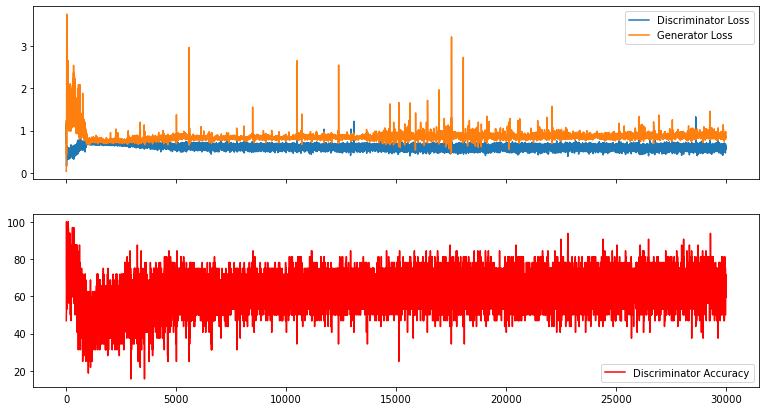

In [16]:
f, (ax1, ax4) = plt.subplots(2, 1, sharex='col', figsize=(13,7))

ax1.plot(itr_list, d_loss_list, label = "Discriminator Loss")
ax1.plot(itr_list, g_loss_list, label = "Generator Loss")
ax1.legend()

# Create two subplots and unpack the output array immediately
ax4.plot(itr_list, acc_list, '-r', label = "Discriminator Accuracy")
ax4.legend()

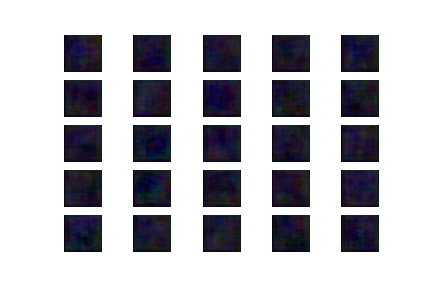

In [17]:
from IPython.display import display
from PIL import Image

path="Resultados_Cafe/itr_0.png"
display(Image.open(path))

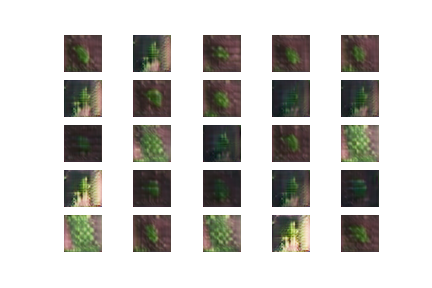

In [18]:
from IPython.display import display
from PIL import Image

path="Resultados_Cafe/itr_30000.png"
display(Image.open(path))

## Test con pesos guardados

In [19]:
optimizer = Adam(0.0002, 0.5)

new_model = build_generator()
new_model.compile(loss='binary_crossentropy', optimizer=optimizer)

new_model.load_weights('generator_64_64_weigths.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
reshape_3 (Reshape)          (None, 2, 2, 64)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 2, 2, 64)          256       
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 1024)        1639424   
_________________________________________________________________
activation_12 (Activation)   (None, 4, 4, 1024)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 1024)       

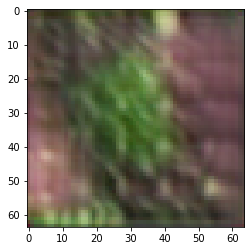

In [20]:
noise = np.random.normal(0, 1, (1,latent_dim))
gen_imgs = new_model.predict(noise)

gen_imgs2 = abs(gen_imgs)

plt.imshow((gen_imgs2[0] * 255).astype(int))
plt.show()

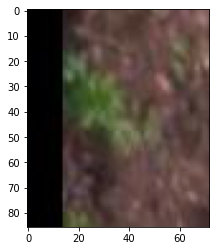

In [21]:
a = cv2.imread('./source/trainingSet/trainingCoffee/000004.jpg')
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(a)
plt.show()